# Generative Models Part 1

In [236]:
%pip install torch==1.7.1 torchvision==0.8.2
%pip install tqdm
%enable_full_walk

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [229]:
%matplotlib inline

from tqdm.auto import tqdm, trange

import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt

from PIL import Image
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage, CenterCrop, ToTensor, Resize, GaussianBlur


def to_image(tensor, adaptive=False):
    if len(tensor.shape) == 4:
        tensor = tensor[0]
    if adaptive:
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    else:
        tensor = ((tensor + 1) / 2).clamp(0, 1)
    return ToPILImage()((255 * tensor.cpu().detach()).to(torch.uint8))


def to_image_grid(tensor, adaptive=False, **kwargs):
    return to_image(make_grid(tensor, **kwargs), adaptive)

## LPIPS

https://richzhang.github.io/PerceptualSimilarity/

In [238]:
#!L
%enable_full_walk
%pip install lpips
import lpips
lpips_dist = lpips.LPIPS('alexnet').cuda()

Defaulting to user installation because normal site-packages is not writeable
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/jupyter/.local/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth


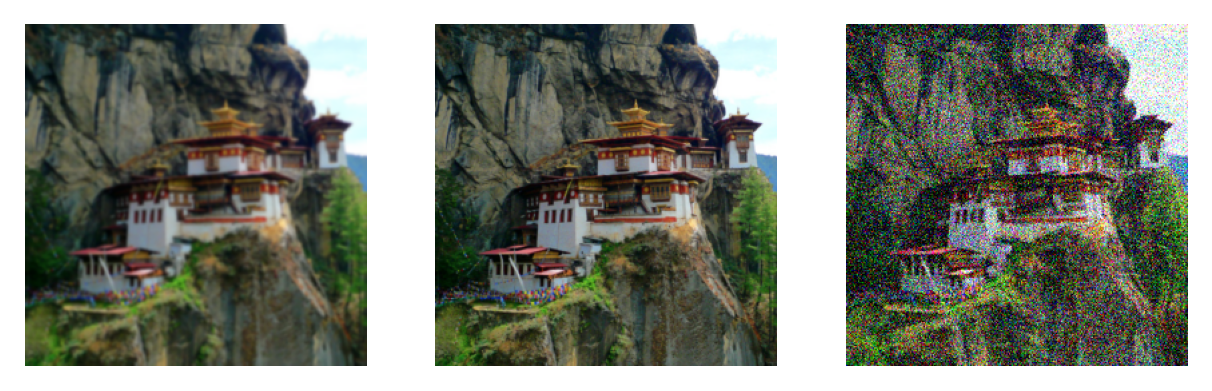

In [239]:
#!L
img = CenterCrop(256)(Resize(256)(Image.open('sample.png')))
ref_img = ToTensor()(img)[:3]
normalize = lambda x: 2 * x.unsqueeze(0) - 1

img_blured = normalize(ToTensor()(GaussianBlur(5)(img))[:3]).cuda()
ref_img = normalize(ref_img.cuda())
img_noised = ref_img + 0.4 * torch.randn_like(ref_img).cuda()


_, axs = plt.subplots(1, 3, dpi=250)
for ax in axs: ax.axis('off')
    
axs[0].imshow(to_image(img_blured))
axs[1].imshow(to_image(ref_img))
axs[2].imshow(to_image(img_noised))

# axs[0].set_title(f'{lpips_dist(img_blured, ref_img).item(): 0.2f}');
# axs[2].set_title(f'{lpips_dist(img_noised, ref_img).item(): 0.2f}');

## Deep Image Prior

https://dmitryulyanov.github.io/deep_image_prior

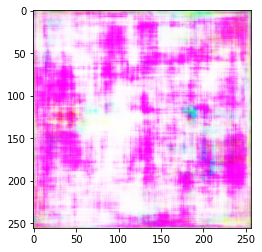

In [240]:
#!L
from resnet18_gen import make_resnet_generator, RES_GEN_CONFIGS


torch.manual_seed(0)
G_ref = make_resnet_generator(RES_GEN_CONFIGS[256])
G_ref.cuda().eval()

with torch.no_grad():
    z = torch.randn([1, G_ref.dim_z], device='cuda')
    img = G_ref(z)
    plt.imshow(to_image_grid(img))

In [241]:
#!L
from copy import deepcopy


def optimize_deep_image_prior(ref_img, lpips_weight: float, mask: torch.Tensor):
    n_steps = 2000

    G = deepcopy(G_ref)
    G.cuda().train()

    opt = torch.optim.Adam(G.parameters())
    mse = nn.MSELoss()

    for step in trange(n_steps):
        G.zero_grad()
        rec = G(z)

        rec_loss = (1.0 - lpips_weight) * mse(mask * rec, mask * ref_img) + \
                    lpips_weight * lpips_dist(mask * rec, mask * ref_img)
        rec_loss.backward()
        opt.step()

    return rec, G

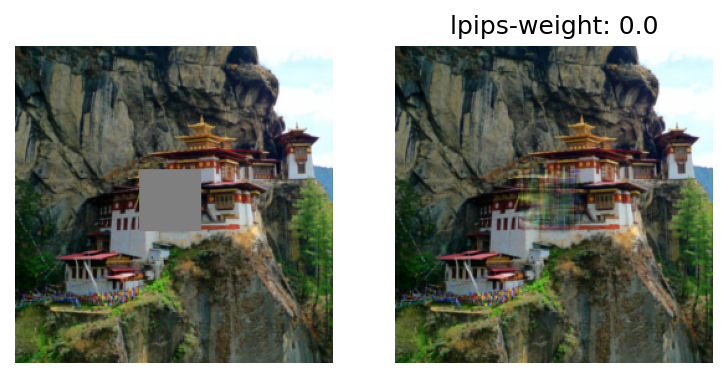

In [242]:
#!L
_, axs = plt.subplots(1, 2, dpi=150)
for ax in axs: ax.axis('off')

mask = torch.ones_like(ref_img)
mask[:, :, 100: 150, 100: 150] = 0.0
rec = optimize_deep_image_prior(ref_img, 0.0, mask)[0]
 
plt.title('lpips-weight: 0.0')
axs[0].imshow(to_image(mask * rec, True))
axs[1].imshow(to_image(rec, True))

In [ ]:
#!L
_, axs = plt.subplots(1, 2, dpi=150)
for ax in axs: ax.axis('off')

mask = torch.ones_like(ref_img)
mask[:, :, 100: 150, 100: 150] = 0.0
rec = optimize_deep_image_prior(ref_img, 1.0, mask)[0]
 
plt.title('lpips-weight: 1.0')
axs[0].imshow(to_image(mask * rec, True))
axs[1].imshow(to_image(rec, True))

In [ ]:
#!L
_, axs = plt.subplots(1, 2, dpi=150)
for ax in axs: ax.axis('off')

mask = torch.ones_like(ref_img)
mask[:, :, 100: 150, 100: 150] = 0.0
rec, G = optimize_deep_image_prior(ref_img, 0.5, mask)
    
plt.title('lpips-weight: 0.5')
axs[0].imshow(to_image(mask * rec, True))
axs[1].imshow(to_image(rec, True))

In [ ]:
#!L
def activations_save_hook(self, input, out):
    setattr(self, 'activations', out)
    return out

for i in range(len(G)):
    G[i].register_forward_hook(activations_save_hook)

with torch.no_grad():
    G(z)

In [ ]:
#!L
for i, axs in enumerate(plt.subplots(len(G), 1, dpi=250)[1]):
    axs.axis('off')
    axs.text(0, -0.7, f'layer {i}', fontdict=dict(size=4, color='red'))
    axs.imshow(to_image_grid(G[i].activations[0, :8].unsqueeze(1), True))

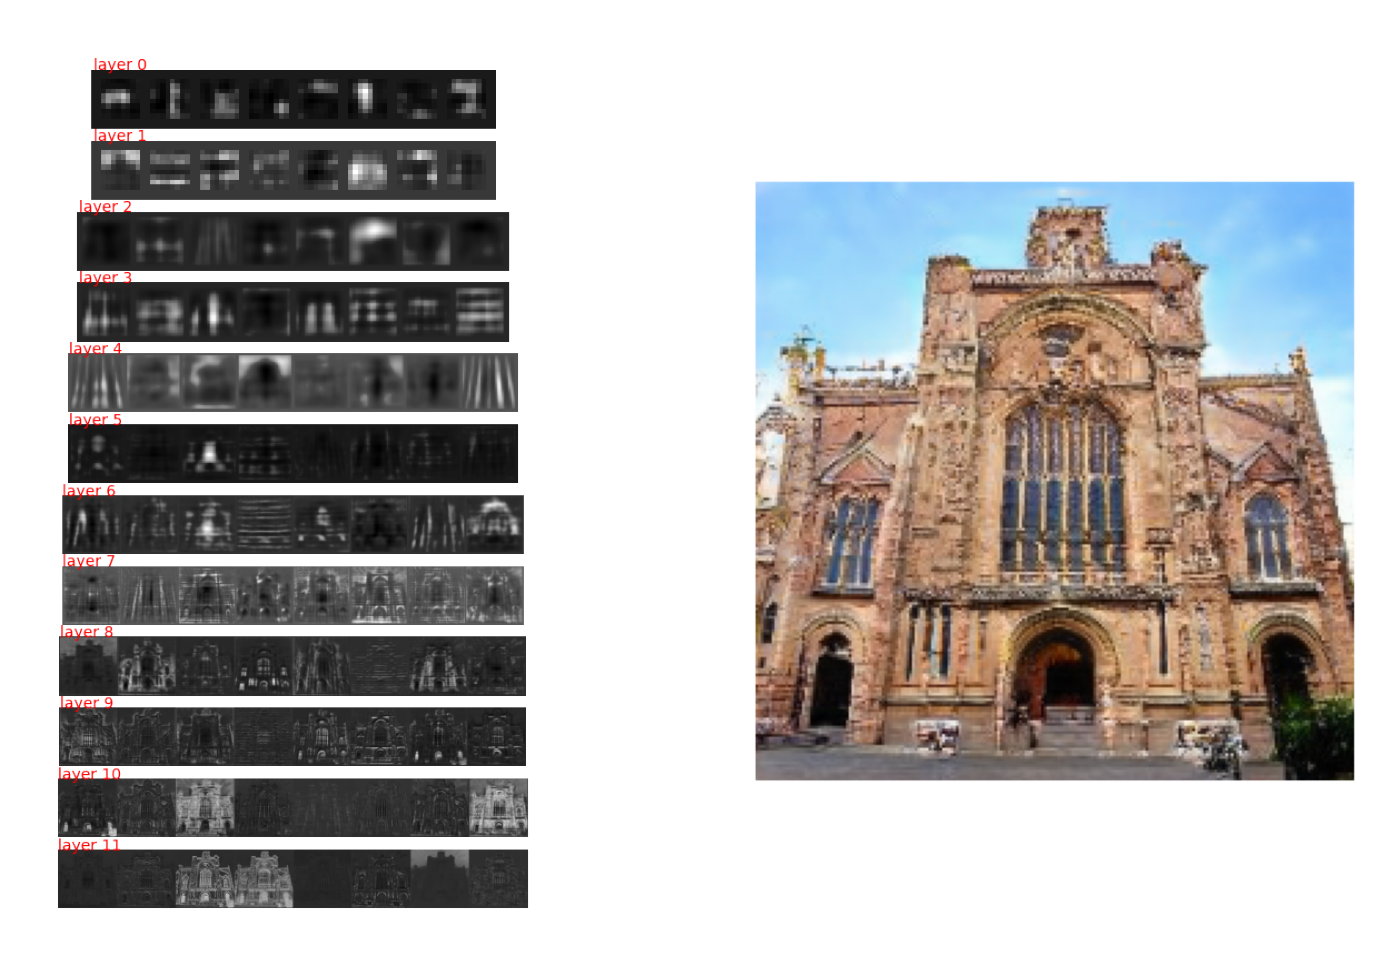

In [244]:
#!L
plt.figure(dpi=300)
plt.subplot(121)
plt.axis('off')
plt.imshow(Image.open('stylegan2_activations.png'))

plt.subplot(122)
plt.axis('off')
plt.imshow(Image.open('stylegan2_sample.png'))

## Normalizing Flows

https://arxiv.org/pdf/1908.09257.pdf

In [245]:
#!L
class LinearFlowBlock(nn.Linear):
    def __init__(self, dim):
        super(LinearFlowBlock, self).__init__(dim, dim, bias=True)
        self.weight.data = torch.eye(2)
        
    def inverse(self, ys):
        ys = F.linear(ys - self.bias, torch.inverse(self.weight))
        log_det = -torch.log(self.weight.det().abs())
        return ys, log_det

    def forward(self, zs):
        return super(LinearFlowBlock, self).forward(zs)
        return 


class LeakyReLUFlowBlock(nn.LeakyReLU):
    def __init__(self, alpha):
        super(LeakyReLUFlowBlock, self).__init__(alpha)
        assert alpha > 0, "flow block must be invertible"

    def forward(self, zs):
        return super(LeakyReLUFlowBlock, self).forward(zs)
    
    def inverse(self, ys):
        ones = torch.ones_like(ys)
        slope = 1.0 / self.negative_slope
        scales = torch.where(ys >= 0, ones, slope * ones)

        return torch.where(ys >= 0, ys, slope * ys),\
               torch.log(scales.abs()).sum(1, keepdim=True)


class NormalizingFlow(nn.Module):
    def __init__(self, *blocks):
        super(NormalizingFlow, self).__init__()
        self.blocks = nn.Sequential(*blocks)

    def inverse(self, ys):
        log_det = torch.zeros([len(ys), 1], dtype=ys.dtype)
        for block in self.blocks[::-1]:
            ys, block_log_det = block.inverse(ys)
            log_det += block_log_det

        return ys, log_det

    def forward(self, zs):
        return self.blocks(zs)

In [ ]:
#!L
class Circle():
    def __init__(self, center):
        self.center = center

    def __call__(self, size):
        n = torch.randn([size, 2])
        n = n / n.norm(dim=-1).unsqueeze(1)
        return n + self.center + 0.1 * torch.randn([size, 2])


distribution = Circle(torch.tensor([4, 4]))
ys = distribution(1024)

nf = NormalizingFlow(
    LinearFlowBlock(2),
    LeakyReLUFlowBlock(0.02),
    LinearFlowBlock(2),
    LeakyReLUFlowBlock(0.02),
    LinearFlowBlock(2),
    LeakyReLUFlowBlock(0.02),
)


plt.subplot(121)
plt.title('ys')
plt.scatter(ys[:, 0], ys[:, 1], alpha=0.3, color='orange')

with torch.no_grad():
    zs, dets = nf.inverse(ys)
plt.subplot(122)
plt.title('z = nf.inverse(ys)')
plt.scatter(zs[:, 0], zs[:, 1], alpha=0.3, color='blue')

In [ ]:
#!L
n_steps = 5_000
rate = 0.002
batch = 2048


nf.train()
opt = torch.optim.SGD(nf.parameters(), rate)


losses = []
for step in trange(n_steps):
    opt.zero_grad()
    ys = distribution(batch)
    zs, log_dets = nf.inverse(ys)

    # p = log p_z(f(y)) + log | det(Df|y) |
    log_prob = -0.5 * (zs.norm(dim=1)**2).mean() + log_dets.mean()
    loss = -log_prob
    loss.backward()
    losses.append(loss.item())
    opt.step()

    
print(f'Log-prob: {loss.item(): 0.3f}')
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(losses)

with torch.no_grad():
    zs = torch.randn([1024, 2])
    ys = nf(zs)
    ys_ref = distribution(1024)

plt.subplot(122)
plt.scatter(zs[:, 0], zs[:, 1], color='blue', alpha=0.2)
plt.scatter(ys_ref[:, 0], ys_ref[:, 1], color='orange', alpha=0.1)
plt.scatter(ys[:, 0], ys[:, 1], color='green', alpha=0.1)